### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Trotterização - Implementação no ibm_jakarta

In [6]:
from qiskit import QuantumCircuit, IBMQ, Aer
def qc_ezz(t):
    qc = QuantumCircuit(2, name = 'e^(-itZZ)')
    qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1) 
    return qc
def qc_exx(t):
    qc = QuantumCircuit(2, name = 'e^(-itXX)')
    qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1])
    return qc
def qc_eyy(t):
    qc = QuantumCircuit(2, name = 'e^(-itYY)')
    qc.sdg([0,1]); qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1]); qc.s([0,1])
    return qc
def qc_Bj(t):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    return qc

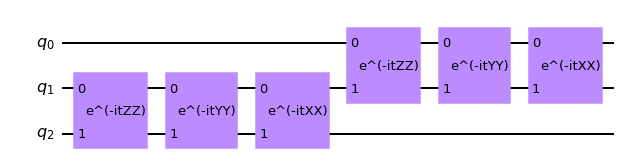

In [2]:
import math
qc_Bj_ = qc_Bj(math.pi)
qc_Bj_.draw(output = 'mpl')

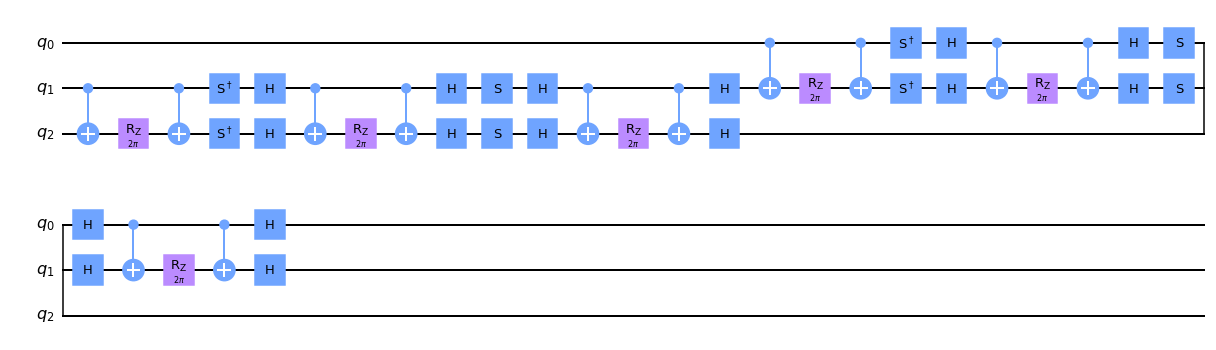

In [3]:
qc_Bj_.decompose().draw(output = 'mpl')

In [7]:
nshots = 8192
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_jakarta')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import backend_overview, backend_monitor

chip jakarta
<img src = 'fig_jakarta_chip.png' width = '600'>

In [8]:
def qc_psi0():
    qc = QuantumCircuit(3, name = 'psi0')
    qc.x([0,1])
    return qc
import numpy as np
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0_ = np.kron(ket1, np.kron(ket1, ket0)); 
psi0__ = np.kron(ket0, np.kron(ket1, ket1)) # para calcular a fidelidade com o estado da tomografia
psi0_.T, psi0__.T

(array([[0, 0, 0, 0, 0, 0, 1, 0]]), array([[0, 0, 0, 1, 0, 0, 0, 0]]))

In [9]:
import scipy
I = np.array([[1,0],[0,1]]); X = np.array([[0,1],[1,0]]); Y = np.array([[0,-1j],[1j,0]]); Z = np.array([[1,0],[0,-1]])
H2 = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)
def UHxxx12_num(t):
    H = np.kron(H2, I)
    return scipy.linalg.expm(-1j*t*H)
def UHxxx23_num(t):
    H = np.kron(I, H2)
    return scipy.linalg.expm(-1j*t*H)
#U = UHxxx23_num(math.pi); print(U.shape[0])

In [13]:
from qiskit import quantum_info, execute
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [14]:
t = math.pi
for j in range(0, 8): # muda o No. de passos de Trotter
    # teórico
    U12 = UHxxx12_num(t/(j+1)); U23 = UHxxx23_num(t/(j+1))
    B = np.dot(U12, U23); U = np.linalg.matrix_power(B, j+1); psit = np.dot(U, psi0_)
    F_teo = quantum_info.state_fidelity(psi0_, psit)
    # circuit q
    qc = QuantumCircuit(7)
    qc.x([5, 3]) # initial state
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulação
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim = quantum_info.state_fidelity(psi0__, rho_sim)
    # experimento
    job_exp = execute(qstc, backend = device, shots = nshots)
    job_monitor(job_exp)
    qstf_exp = StateTomographyFitter(job_exp.result(), qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp = quantum_info.state_fidelity(psi0__, rho_exp)
    print('No. passos=', j+1, ',F_teo=', F_teo, ',F_sim=', F_sim, ',F_exp=', F_exp)

Job Status: job has successfully run
No. passos= 1 ,F_teo= 1.0 ,F_sim= 0.9958882254932865 ,F_exp= 0.8869198627311783
Job Status: job has successfully run
No. passos= 2 ,F_teo= 1.0 ,F_sim= 0.9969185246651309 ,F_exp= 0.4945945384641882
Job Status: job has successfully run
No. passos= 3 ,F_teo= 0.07714843750000018 ,F_sim= 0.0778206969050526 ,F_exp= 0.10523544593902089
Job Status: job has successfully run
No. passos= 4 ,F_teo= 0.0 ,F_sim= 5.969854588581241e-05 ,F_exp= 0.09089799973348599
Job Status: job has successfully run
No. passos= 5 ,F_teo= 0.2568610946774409 ,F_sim= 0.2592369197912683 ,F_exp= 0.09748134832530922
Job Status: job has successfully run
No. passos= 6 ,F_teo= 0.573213338851928 ,F_sim= 0.5718147466697812 ,F_exp= 0.11186698596994515
Job Status: job has successfully run
No. passos= 7 ,F_teo= 0.7584840269784399 ,F_sim= 0.7542218755513783 ,F_exp= 0.1216007277291585
Job Status: job has successfully run
No. passos= 8 ,F_teo= 0.857330322265624 ,F_sim= 0.8522606698370779 ,F_exp= 0.

In [ ]:
qc.draw(output = 'mpl')

Na sequência farei alguns gráficos de $F\times t$ para tentar entender melhor o que está acontecendo.

In [ ]:
npt = 7
dt = math.pi/16; t = np.arange(0, math.pi+dt, dt); d = len(t)
F_teo = np.zeros(d); F_sim = np.zeros(d); F_exp = np.zeros(d)
for j in range(0, d):
    # teórico
    U12 = UHxxx12_num(t[j]/npt); U23 = UHxxx23_num(t[j]/npt)
    B = np.dot(U12, U23); U = np.linalg.matrix_power(B, npt); psit = np.dot(U, psi0_)
    F_teo[j] = qiskit.quantum_info.state_fidelity(psi0_, psit)
    # circuito quântico
    qc = QuantumCircuit(7); qc.x([5, 3]) # initial state
    qc_Bj_ = qc_Bj(t[j]/npt)
    for k in range(0, npt):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulação
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim[j] = quantum_info.state_fidelity(psi0__, rho_sim)
    # experimento
    job_exp = execute(qstc, backend = device, shots = nshots)
    job_monitor(job_exp)
    qstf_exp = StateTomographyFitter(job_exp.result(), qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp[j] = quantum_info.state_fidelity(psi0__, rho_exp)
qc.draw(output = 'mpl')

In [ ]:
print('t = ', t[j], 'F_exp = ', F_exp[j])

In [ ]:
%run init.ipynb
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(t, F_teo, '-.', label = r'$F_{teo}$'); plt.plot(t, F_sim, '-.', label = r'$F_{sim}$')
plt.plot(t, F_exp, '-.', label = r'$F_{exp}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()